In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="white")

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
%matplotlib inline
import math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Read data

In [3]:
df = pd.read_csv('nyc_taxis.csv', index_col = 'id')
df.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255


**Information**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


# 1.1 Data Cleaning

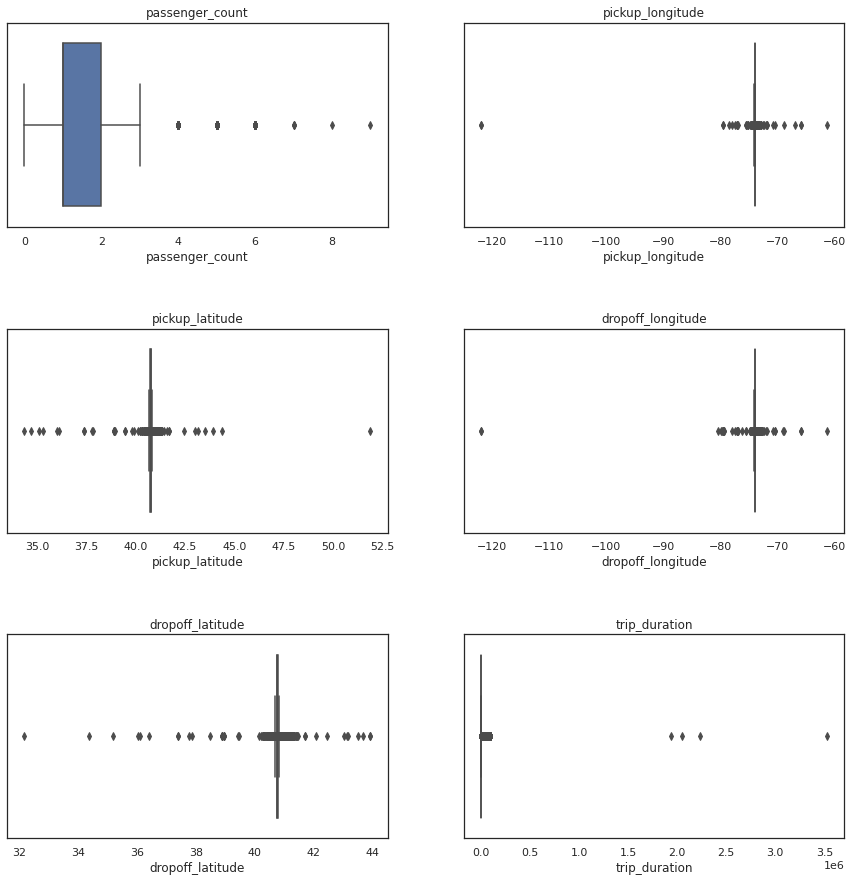

In [5]:
cols=['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']
fig, axes = plt.subplots(nrows = 3, ncols = 2)  
axes = axes.flatten()         
fig.set_size_inches(15, 15)
fig.subplots_adjust(hspace=0.5)

for ax, col in zip(axes, df[cols]):
    sns.boxplot(x = df[col], ax = ax)
    ax.set_title(col)

Looking at trip_duration, we can see clear ouliers from the rest of the data. Will remove these outliers.

In [6]:
df = df[df['trip_duration'] < 1.5e6]

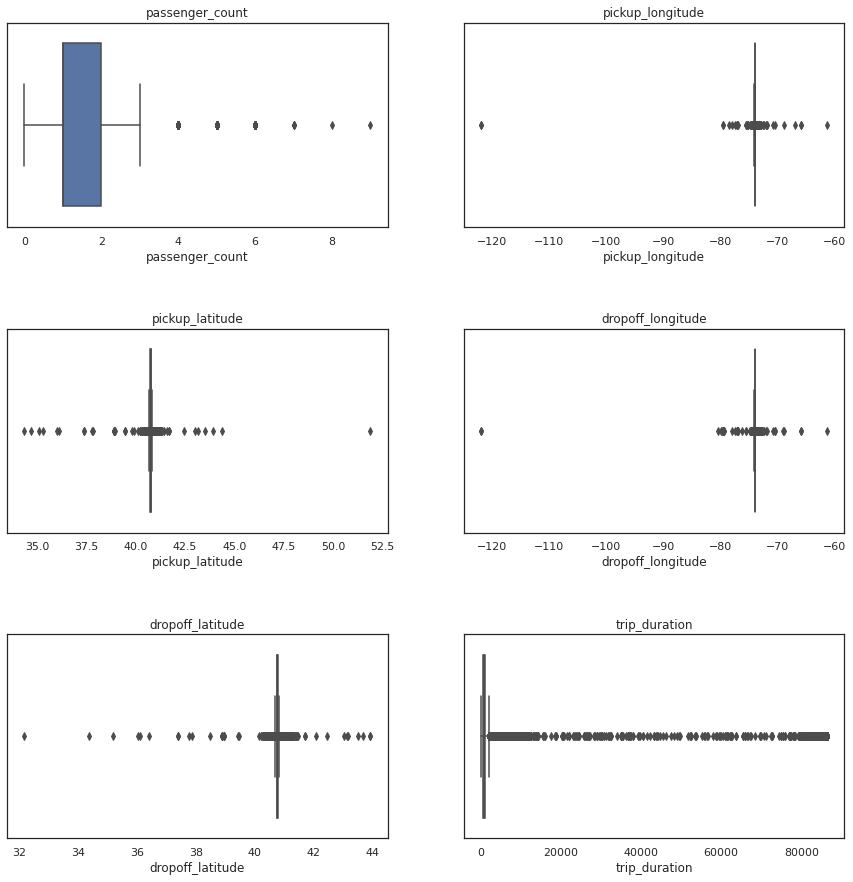

In [7]:
fig, axes = plt.subplots(nrows = 3, ncols = 2)  
axes = axes.flatten()         
fig.set_size_inches(15, 15)
fig.subplots_adjust(hspace=0.5)

for ax, col in zip(axes, df[cols]):
    sns.boxplot(x = df[col], ax = ax)
    ax.set_title(col)

Removed 4 most outliers of the trip_deration from the data <br>
We can remove these outliers since it is not normal to come across these points in the data.

# 1.2 Feature generation

## Create distance column

In [7]:
def haversine_dist(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    
    :params lon1: First point longitude in degrees
    :params lat1: First point latitude in degrees
    :params lon2: Second point longitude in degress
    :params lat2: Second point latitude in degrees
    
    :returns distance in kilometers
    """
    # Convert decimal degrees to radians 
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth(km)
    
    distance = c*r
    
    return np.round(distance,decimals=3)

In [8]:
# Calculate distance(km)
df['trip_dist'] = haversine_dist(df['pickup_longitude'], df['pickup_latitude'], 
              df['dropoff_longitude'], df['dropoff_latitude'])
df.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist
id,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.099
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.715
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310


## Create date columns

**Convert date columns to datetime**

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Adding day of week
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

df['dropoff_weekday'] = df['dropoff_datetime'].dt.weekday

## Create average speed column

In [10]:
# Average speed(km/hr)
df['ave_speed'] = df['trip_dist']/(df['trip_duration'].apply(lambda x: x/3600))
df['ave_speed'] = df['ave_speed'].round(decimals = 2)
df.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist,pickup_weekday,dropoff_weekday,ave_speed
id,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,0,0,11.86
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,6,6,9.81
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,1,1,10.82
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,2,2,12.46
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,5,5,9.84
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.099,5,5,8.93
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326,4,4,14.00
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.715,5,5,13.26
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310,4,4,18.49


**Save dataset**

In [ ]:
df.to_csv('clean_nyc_taxis.csv')

# 1.3 Time-based Questions

## Question 1.3.1

In [11]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

/home/thabo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


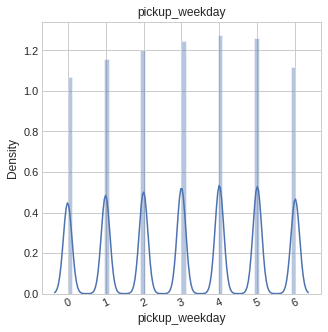

In [12]:
plot_distribution(df[['pickup_weekday']], cols=3, width=20, height=5, hspace=0.5, wspace=0.5)

In [13]:
df['pickup_weekday'].value_counts().idxmax()

4

Most popular day is friday which is 4

## Question 1.3.2

In [14]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [15]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist,pickup_weekday,dropoff_weekday,ave_speed,pickup_hour
id,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,0,0,11.86,17
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,6,6,9.81,0
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,1,1,10.82,11
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,2,2,12.46,19
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,5,5,9.84,13


In [16]:
peak_hour_of_day = df.groupby('pickup_weekday').agg({'pickup_hour':pd.Series.mode})

In [17]:
peak_hour_of_day

,pickup_hour
pickup_weekday,
0,18
1,18
2,19
3,21
4,19
5,23
6,0


On a Monday most people pickup at 6pm <br>
On a Tuesday most people pickup at 6pm <br>
On a Wednesday most people pickup at 7pm <br>
On a Thursday most people pickup at 9pm <br>
On a Friday most people pickup at 7pm <br>
On a Saturday most people pickup at 11pm <br>
On a Sunday most people pickup at 12am

/home/thabo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


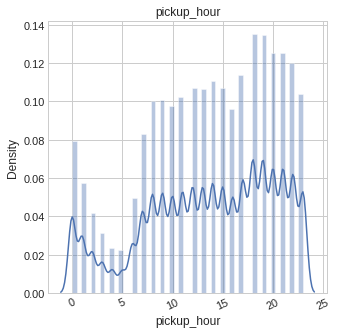

In [18]:
plot_distribution(df[['pickup_hour']], cols=3, width=20, height=5, hspace=0.5, wspace=0.5)

Most people pickup at 6pm <br>
This can be due to that most people are coming back from work at that time

## Question 1.3.3

In [19]:
hours_in_day = df.groupby('pickup_weekday')['pickup_hour'].apply(list)

Weekdays

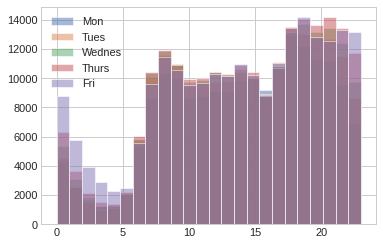

In [20]:
plt.hist(hours_in_day[0], 24,label='Mon',alpha = 0.5)
plt.hist(hours_in_day[1], 24,label='Tues',alpha = 0.5)
plt.hist(hours_in_day[2], 24,label='Wednes',alpha = 0.5)
plt.hist(hours_in_day[3], 24,label='Thurs',alpha = 0.5)
plt.hist(hours_in_day[4], 24,label='Fri',alpha = 0.5)
plt.legend()

Weekends

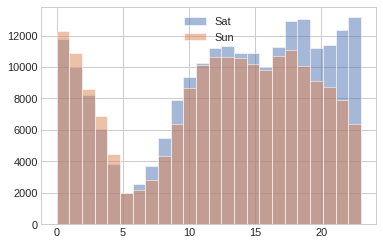

In [21]:
plt.hist(hours_in_day[5], 24,label='Sat',alpha = 0.5)
plt.hist(hours_in_day[6], 24,label='Sun',alpha = 0.5)
plt.legend()

Weekday VS Weekend

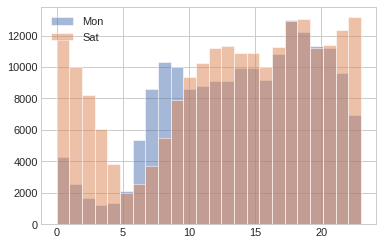

In [22]:
plt.hist(hours_in_day[0], 24,label='Mon',alpha = 0.5)
plt.hist(hours_in_day[5], 24,label='Sat',alpha = 0.5)
plt.legend()

On weekends most people like to pickup at early Morning 12am to 5am. <br>
Saturday is similar to weekdays but there are more pickups in the early hours 12am to 5am <br>
On Sunday after 6pm most people don't pickup anymore. <br>
The early pickups on weekend might be due to people traveling to vist there families.
We can also see that not much pickups happen at 5am to 10am at the weekends, this can be due to people not going to work.

## Question 1.3.4

In [23]:
cal = calendar()
Holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())
df['Holiday'] = df['pickup_datetime'].dt.date.astype('datetime64').isin(Holidays)

In [24]:
Holidays

DatetimeIndex(['2016-01-18', '2016-02-15', '2016-05-30'], dtype='datetime64[ns]', freq=None)

In [25]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist,pickup_weekday,dropoff_weekday,ave_speed,pickup_hour,Holiday
id,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,0,0,11.86,17,False
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,6,6,9.81,0,False
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,1,1,10.82,11,False
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,2,2,12.46,19,False
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,5,5,9.84,13,False


In [26]:
Holidays_df = df[df['Holiday'] == True]

In [27]:
Holidays_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist,pickup_weekday,dropoff_weekday,ave_speed,pickup_hour,Holiday
id,,,,,,,,,,,,,,,,
id0675800,2,2016-02-15 09:25:15,2016-02-15 09:35:49,6,-73.977753,40.754631,-74.001678,40.756420,N,634,2.025,0,0,11.50,9,True
id2648478,1,2016-01-18 11:13:59,2016-01-18 11:18:56,1,-73.951576,40.766468,-73.960213,40.760540,N,297,0.982,0,0,11.90,11,True
id1674373,2,2016-02-15 17:52:27,2016-02-15 18:02:13,5,-74.007500,40.740952,-74.016647,40.704910,N,586,4.081,0,0,25.07,17,True
id2677357,2,2016-02-15 16:36:19,2016-02-15 16:41:50,2,-73.971634,40.781963,-73.981689,40.778996,N,331,0.909,0,0,9.89,16,True
id3013319,2,2016-02-15 22:28:54,2016-02-15 22:30:27,1,-73.981400,40.778793,-73.976524,40.782497,N,93,0.581,0,0,22.49,22,True


In [28]:
hours_in_day_holidays = Holidays_df.groupby('pickup_weekday')['pickup_hour'].apply(list)

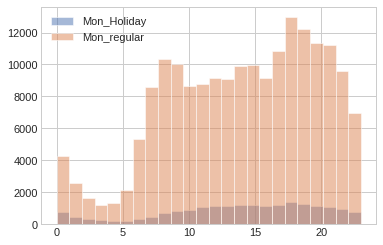

In [29]:
plt.hist(hours_in_day_holidays[0], 24,label='Mon_Holiday',alpha = 0.5)
plt.hist(hours_in_day[0], 24,label='Mon_regular',alpha = 0.5)
plt.legend()

Compared to a normal Monday, the one on Holiday indicate that they are far less pickups then normal. <br>
This shows that most people don't work or travel on Holidays

## Question 1.3.5

In [30]:
day_speed = df[['pickup_datetime','ave_speed']]

In [31]:
day_speed.head()

,pickup_datetime,ave_speed
id,,
id2875421,2016-03-14 17:24:55,11.86
id2377394,2016-06-12 00:43:35,9.81
id3858529,2016-01-19 11:35:24,10.82
id3504673,2016-04-06 19:32:31,12.46
id2181028,2016-03-26 13:30:55,9.84


In [32]:
day_speed_df = day_speed.groupby(pd.Grouper(key='pickup_datetime', freq='60min')).mean().dropna()
day_speed_df.head()

,ave_speed
pickup_datetime,
2016-01-01 00:00:00,15.460018
2016-01-01 01:00:00,15.438657
2016-01-01 02:00:00,16.589364
2016-01-01 03:00:00,17.265177
2016-01-01 04:00:00,17.988235


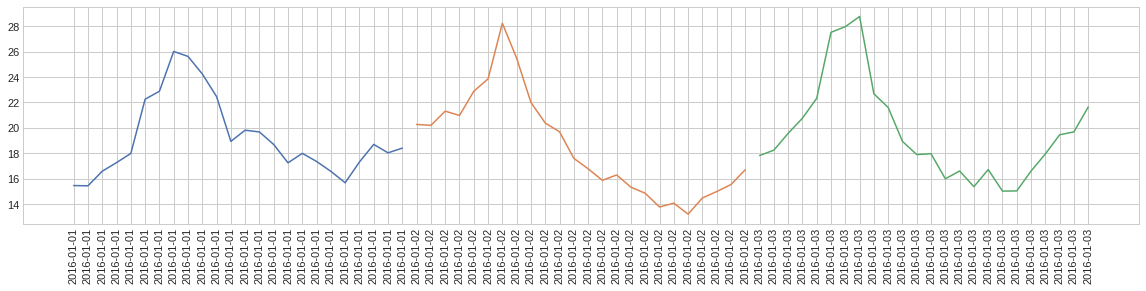

In [33]:
plt.figure(figsize=(20, 4))
plt.plot(day_speed_df.index[:24],day_speed_df.values[:24])
plt.plot(day_speed_df.index[24:48],day_speed_df.values[24:48])
plt.plot(day_speed_df.index[48:72],day_speed_df.values[48:72])
plt.xticks(rotation=90)
plt.xticks(day_speed_df.index[:72])
plt.show()

From the graphs it is seen that at around 5am to 8am the highest average speeds are archieved around 70 to 85. This can be caused by people rushing to work. <br>
The slowest speeds are around 5pm to 8pm. This is when the taxis travel the slowest below 40. This can be due to traffic when everyone is returning from work and because people are not necessary in a rush when returning from work.